In [17]:
# Import libraries
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import helper
from itertools import product

In [18]:
# Load retention time data
tdata = pd.read_csv("../data/retention/retention.min.csv.gz")

# Time point
timept = 100000

In [3]:
# Get PBA allocations
pba_allocations_bpc = {1: set(), 2: set()}
for gamma in np.arange(0, 0.0031, 0.0001):
    print("gamma =", gamma)
    lvlcands = {}
    for (lower, upper), d in tdata[tdata["timept"] == timept].groupby(["lower","upper"]):
        lvlcand = d.mean()[["timept","lower","upper","width","successes","failures","reads","sets","resets","cycles","read_bits","set_bits","reset_bits","lvl","time"]].to_dict()
        lvl, cdf = sorted(d["lvl"].values), np.linspace(0.5/len(d), 1-0.5/len(d), len(d)) # symmetric percentile CDF (https://math.stackexchange.com/questions/33488/how-to-calculate-percentile-is-it-possible-to-get-100-percentile)
        try:
            lvlcand["lower_rd"] = int(np.floor(helper.intersection(np.array([0,64]), np.array([gamma,gamma]), np.array(lvl), cdf)[0][0]))
            lvlcand["upper_rd"] = int(np.ceil(helper.intersection(np.array([0,64]), np.array([1-gamma,1-gamma]), np.array(lvl), cdf)[0][0]))
            lvlcands[(int(lower), int(upper))] = lvlcand
        except IndexError:
            continue

    pba_allocations = []
    cur_upper = -1
    while True:
        cands = [lvlcand for lvlcand in lvlcands.values() if lvlcand["lower_rd"] > cur_upper]
        if cands == []:
            break
        next_cur_upper = min([cand["upper_rd"] for cand in cands])
        pba_allocations.append([(int(cand["lower"]), int(cand["upper"])) for cand in cands if cand["upper_rd"] == next_cur_upper])
        cur_upper = next_cur_upper
    print(pba_allocations)
    if pba_allocations != []:
        pba_allocations_bpc[1].update(product(*pba_allocations[:2]))
        pba_allocations_bpc[2].update(product(*pba_allocations[:4]))
pba_allocations_bpc

gamma = 0.0
[]
gamma = 0.0001
[]
gamma = 0.0002
[]
gamma = 0.00030000000000000003
[]
gamma = 0.0004
[]
gamma = 0.0005
[[(3, 12)], [(35, 42)], [(52, 57)], [(61, 63), (63, 63)]]
gamma = 0.0006000000000000001
[[(3, 12)], [(35, 42)], [(52, 57)], [(61, 63), (63, 63)]]
gamma = 0.0007
[[(3, 12)], [(35, 42)], [(52, 57)], [(61, 63), (63, 63)]]
gamma = 0.0008
[[(3, 12)], [(35, 42)], [(52, 57)], [(61, 63), (63, 63)]]
gamma = 0.0009000000000000001
[[(3, 12)], [(35, 42)], [(52, 57)], [(61, 63), (63, 63)]]
gamma = 0.001
[[(3, 12)], [(35, 42)], [(52, 57)], [(61, 63), (63, 63)]]
gamma = 0.0011
[[(3, 12)], [(35, 42)], [(52, 57)], [(61, 63), (63, 63)]]
gamma = 0.0012000000000000001
[[(3, 12)], [(35, 42)], [(52, 57)], [(61, 63), (63, 63)]]
gamma = 0.0013000000000000002
[[(5, 8)], [(32, 42), (32, 43), (35, 42)], [(52, 57)], [(60, 63), (61, 63), (62, 63), (63, 63)]]
gamma = 0.0014
[[(5, 8)], [(32, 42), (32, 43), (35, 42)], [(52, 57)], [(60, 63), (61, 63), (62, 63), (63, 63)]]
gamma = 0.0015
[[(5, 8)], [(32

{1: {((3, 12), (35, 42)),
  ((5, 8), (28, 33)),
  ((5, 8), (32, 42)),
  ((5, 8), (32, 43)),
  ((5, 8), (35, 42))},
 2: {((3, 12), (35, 42), (52, 57), (61, 63)),
  ((3, 12), (35, 42), (52, 57), (63, 63)),
  ((5, 8), (28, 33), (46, 52), (58, 62)),
  ((5, 8), (28, 33), (47, 52), (58, 62)),
  ((5, 8), (28, 33), (47, 52), (60, 62)),
  ((5, 8), (32, 42), (52, 57), (59, 63)),
  ((5, 8), (32, 42), (52, 57), (60, 63)),
  ((5, 8), (32, 42), (52, 57), (61, 63)),
  ((5, 8), (32, 42), (52, 57), (62, 63)),
  ((5, 8), (32, 42), (52, 57), (63, 63)),
  ((5, 8), (32, 43), (52, 57), (60, 63)),
  ((5, 8), (32, 43), (52, 57), (61, 63)),
  ((5, 8), (32, 43), (52, 57), (62, 63)),
  ((5, 8), (32, 43), (52, 57), (63, 63)),
  ((5, 8), (35, 42), (52, 57), (59, 63)),
  ((5, 8), (35, 42), (52, 57), (60, 63)),
  ((5, 8), (35, 42), (52, 57), (61, 63)),
  ((5, 8), (35, 42), (52, 57), (62, 63)),
  ((5, 8), (35, 42), (52, 57), (63, 63))}}

In [4]:
# Digraph
DG = nx.DiGraph()
DG.add_nodes_from(lvlcands.items())
DG.add_edges_from([(cand1, cand2) for cand1 in lvlcands for cand2 in lvlcands if lvlcands[cand2]["lower_rd"] > lvlcands[cand1]["upper_rd"]])
DG.number_of_nodes(), DG.number_of_edges()

(2017, 31488)

In [5]:
# Get all possible level allocations
allocations = []
for root in [(j,i) for i in range(64) for j in range(10)]:
  for leaf in [(i,63) for i in range(64)]:
    print("ROOT", root, "LEAF", leaf)
    try:
      for path in nx.all_simple_paths(DG, root, leaf):
        allocations.append(tuple(path))  
    except nx.NodeNotFound:
       pass
len(allocations)

ROOT (0, 0) LEAF (0, 63)
ROOT (0, 0) LEAF (1, 63)
ROOT (0, 0) LEAF (2, 63)
ROOT (0, 0) LEAF (3, 63)
ROOT (0, 0) LEAF (4, 63)
ROOT (0, 0) LEAF (5, 63)
ROOT (0, 0) LEAF (6, 63)
ROOT (0, 0) LEAF (7, 63)
ROOT (0, 0) LEAF (8, 63)
ROOT (0, 0) LEAF (9, 63)
ROOT (0, 0) LEAF (10, 63)
ROOT (0, 0) LEAF (11, 63)
ROOT (0, 0) LEAF (12, 63)
ROOT (0, 0) LEAF (13, 63)
ROOT (0, 0) LEAF (14, 63)
ROOT (0, 0) LEAF (15, 63)
ROOT (0, 0) LEAF (16, 63)
ROOT (0, 0) LEAF (17, 63)
ROOT (0, 0) LEAF (18, 63)
ROOT (0, 0) LEAF (19, 63)
ROOT (0, 0) LEAF (20, 63)
ROOT (0, 0) LEAF (21, 63)
ROOT (0, 0) LEAF (22, 63)
ROOT (0, 0) LEAF (23, 63)
ROOT (0, 0) LEAF (24, 63)
ROOT (0, 0) LEAF (25, 63)
ROOT (0, 0) LEAF (26, 63)
ROOT (0, 0) LEAF (27, 63)
ROOT (0, 0) LEAF (28, 63)
ROOT (0, 0) LEAF (29, 63)
ROOT (0, 0) LEAF (30, 63)
ROOT (0, 0) LEAF (31, 63)
ROOT (0, 0) LEAF (32, 63)
ROOT (0, 0) LEAF (33, 63)
ROOT (0, 0) LEAF (34, 63)
ROOT (0, 0) LEAF (35, 63)
ROOT (0, 0) LEAF (36, 63)
ROOT (0, 0) LEAF (37, 63)
ROOT (0, 0) LEAF (38, 

46231

In [6]:
# Get all 1-2 bpc allocations
allocations_bpc = {1 : [a for a in allocations if len(a) == 2], 2 : [a for a in allocations if len(a) == 4]}
print(allocations_bpc)
{k : len(v) for k, v in allocations_bpc.items()}

{1: [((0, 7), (59, 63)), ((0, 7), (60, 63)), ((0, 7), (61, 63)), ((0, 7), (62, 63)), ((0, 7), (63, 63)), ((4, 7), (59, 63)), ((4, 7), (60, 63)), ((4, 7), (61, 63)), ((4, 7), (62, 63)), ((4, 7), (63, 63)), ((0, 8), (15, 63)), ((0, 8), (17, 63)), ((0, 8), (19, 63)), ((0, 8), (20, 63)), ((0, 8), (21, 63)), ((0, 8), (22, 63)), ((0, 8), (23, 63)), ((0, 8), (24, 63)), ((0, 8), (25, 63)), ((0, 8), (26, 63)), ((0, 8), (27, 63)), ((0, 8), (28, 63)), ((0, 8), (29, 63)), ((0, 8), (30, 63)), ((0, 8), (31, 63)), ((0, 8), (32, 63)), ((0, 8), (33, 63)), ((0, 8), (34, 63)), ((0, 8), (35, 63)), ((0, 8), (36, 63)), ((0, 8), (37, 63)), ((0, 8), (38, 63)), ((0, 8), (39, 63)), ((0, 8), (40, 63)), ((0, 8), (41, 63)), ((0, 8), (42, 63)), ((0, 8), (43, 63)), ((0, 8), (44, 63)), ((0, 8), (45, 63)), ((0, 8), (46, 63)), ((0, 8), (47, 63)), ((0, 8), (48, 63)), ((0, 8), (49, 63)), ((0, 8), (50, 63)), ((0, 8), (51, 63)), ((0, 8), (52, 63)), ((0, 8), (53, 63)), ((0, 8), (54, 63)), ((0, 8), (55, 63)), ((0, 8), (56, 6

{1: 8255, 2: 2308}

In [9]:
# Plot BW-BER tradeoff in level allocations
results = []
for bpc in range(1, 3):
    for i, a in enumerate(allocations_bpc[bpc] + list(pba_allocations_bpc[bpc])):
        if i % 10 == 0:
            print(bpc, i)

        rdbounds = [0]
        for lvl1, lvl2 in zip(a[:-1], a[1:]):
            rdbounds.append(int((lvlcands[lvl1]["upper_rd"] + lvlcands[lvl2]["lower_rd"]) // 2))
        rdbounds.append(64)

        times, confmat = [], []
        for i, lvl in enumerate(a):
            # Get the relevant data
            lvldata = tdata[(tdata["timept"] == timept) & (tdata["lower"] == lvl[0]) & (tdata["upper"] == lvl[1])]

            # Compute average time to target level
            times.append(lvldata["cycles"].mean() * 10e-9)

            # Compute the CER for level
            confvec = []
            for rdbound_low, rdbound_high in zip(rdbounds[:-1], rdbounds[1:]):
                confvec.append(lvldata[(lvldata["lvl"] > rdbound_low) & (lvldata["lvl"] <= rdbound_high)].count()[0])
            confmat.append(confvec)
        times, confmat = np.array(times), np.array(confmat)
        
        # Compute overall results
        bw = 37 / times.mean() * bpc

        # Symbol error magnitudes
        mae = sum(abs(i - j) * confmat[i][j] for i in range(2**bpc) for j in range(2**bpc)) / confmat.sum()
        rmse = np.sqrt(sum((i - j)**2 * confmat[i][j] for i in range(2**bpc) for j in range(2**bpc)) / confmat.sum())

        # Function to get Gray code string
        getgray = lambda x : format(2**(2**bpc) + x^x//2, f"0{2**bpc-1}b")[1:]

        # Function to get Gray code error rate for each possible symbol confusion
        grayerr = np.array([[sum([int(ic != jc) for ic, jc in zip(getgray(i), getgray(j))]) for i in range(2**bpc)] for j in range(2**bpc)]) / bpc

        # BER
        ber = (grayerr * confmat).sum() / confmat.sum()

        # CER
        cer = 1 - confmat.trace() / confmat.sum()

        # Is a PBA allocation
        is_pba = a in pba_allocations_bpc[bpc]

        # Results
        results.append([bpc, a, rdbounds, confmat, bw, ber, cer, is_pba])

# Get dataframe
data = pd.DataFrame(results, columns=["bpc", "allocation", "read_bounds", "confmat", "bw", "ber", "cer", "is_pba"]).sort_values(["ber", "bw"], ascending=[True, False])
data.to_csv("../data/allocation/allocations.csv", index=False)
data

1 0
1 10
1 20
1 30
1 40
1 50
1 60
1 70
1 80
1 90
1 100
1 110
1 120
1 130
1 140
1 150
1 160
1 170
1 180
1 190
1 200
1 210
1 220
1 230
1 240
1 250
1 260
1 270
1 280
1 290
1 300
1 310
1 320
1 330
1 340
1 350
1 360
1 370
1 380
1 390
1 400
1 410
1 420
1 430
1 440
1 450
1 460
1 470
1 480
1 490
1 500
1 510
1 520
1 530
1 540
1 550
1 560
1 570
1 580
1 590
1 600
1 610
1 620
1 630
1 640
1 650
1 660
1 670
1 680
1 690
1 700
1 710
1 720
1 730
1 740
1 750
1 760
1 770
1 780
1 790
1 800
1 810
1 820
1 830
1 840
1 850
1 860
1 870
1 880
1 890
1 900
1 910
1 920
1 930
1 940
1 950
1 960
1 970
1 980
1 990
1 1000
1 1010
1 1020
1 1030
1 1040
1 1050
1 1060
1 1070
1 1080
1 1090
1 1100
1 1110
1 1120
1 1130
1 1140
1 1150
1 1160
1 1170
1 1180
1 1190
1 1200
1 1210
1 1220
1 1230
1 1240
1 1250
1 1260
1 1270
1 1280
1 1290
1 1300
1 1310
1 1320
1 1330
1 1340
1 1350
1 1360
1 1370
1 1380
1 1390
1 1400
1 1410
1 1420
1 1430
1 1440
1 1450
1 1460
1 1470
1 1480
1 1490
1 1500
1 1510
1 1520
1 1530
1 1540
1 1550
1 1560
1 1570
1 158

,bpc,allocation,read_bounds,confmat,bw,ber,cer,is_pba
7230,1,"((0, 45), (52, 63))","[0, 48, 64]","[[1221, 0], [0, 1184]]",3.165045e+07,0.000000,0.000000,False
7229,1,"((0, 45), (51, 63))","[0, 47, 64]","[[1221, 0], [0, 1184]]",3.145704e+07,0.000000,0.000000,False
7232,1,"((0, 45), (54, 63))","[0, 49, 64]","[[1221, 0], [0, 1184]]",3.145704e+07,0.000000,0.000000,False
6912,1,"((1, 42), (52, 63))","[0, 47, 64]","[[1221, 0], [0, 1184]]",3.118562e+07,0.000000,0.000000,False
7234,1,"((0, 45), (56, 63))","[0, 50, 64]","[[1221, 0], [0, 1184]]",3.110989e+07,0.000000,0.000000,False
...,...,...,...,...,...,...,...,...
3580,1,"((1, 22), (60, 63))","[0, 58, 64]","[[1217, 4], [3, 1181]]",4.799159e+05,0.002911,0.002911,False
1708,1,"((7, 14), (60, 63))","[0, 58, 64]","[[1217, 4], [3, 1181]]",4.699668e+05,0.002911,0.002911,False
2410,1,"((9, 16), (60, 63))","[0, 58, 64]","[[1217, 4], [3, 1181]]",4.647585e+05,0.002911,0.002911,False
6,1,"((4, 7), (60, 63))","[0, 58, 64]","[[1217, 4], [3, 1181]]",9.135867e+04,0.002911,0.002911,False


In [19]:
# Load allocations
data = pd.read_csv("../data/allocation/allocations.csv", converters={"allocation": eval, "read_bounds": eval}).drop(columns="confmat")
data

,bpc,allocation,read_bounds,bw,ber,cer,is_pba
0,1,"((0, 45), (52, 63))","[0, 48, 64]",3.165045e+07,0.000000,0.000000,False
1,1,"((0, 45), (51, 63))","[0, 47, 64]",3.145704e+07,0.000000,0.000000,False
2,1,"((0, 45), (54, 63))","[0, 49, 64]",3.145704e+07,0.000000,0.000000,False
3,1,"((1, 42), (52, 63))","[0, 47, 64]",3.118562e+07,0.000000,0.000000,False
4,1,"((0, 45), (56, 63))","[0, 50, 64]",3.110989e+07,0.000000,0.000000,False
...,...,...,...,...,...,...,...
10582,1,"((1, 22), (60, 63))","[0, 58, 64]",4.799159e+05,0.002911,0.002911,False
10583,1,"((7, 14), (60, 63))","[0, 58, 64]",4.699668e+05,0.002911,0.002911,False
10584,1,"((9, 16), (60, 63))","[0, 58, 64]",4.647585e+05,0.002911,0.002911,False
10585,1,"((4, 7), (60, 63))","[0, 58, 64]",9.135867e+04,0.002911,0.002911,False


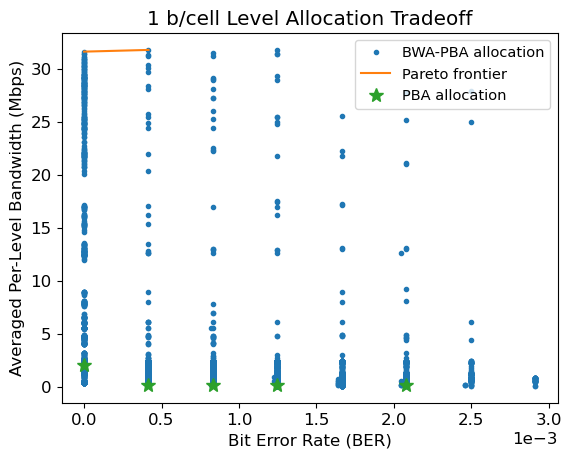

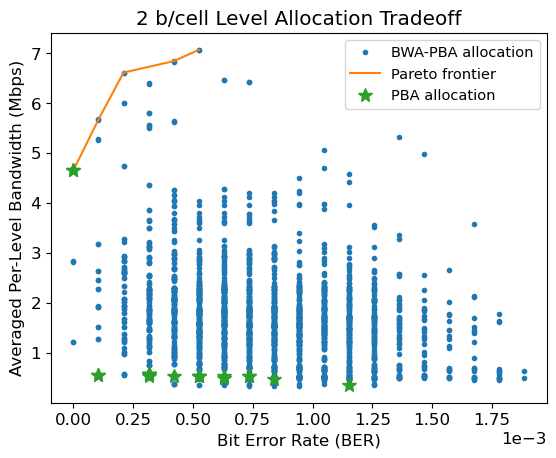

,bpc,allocation,read_bounds,bw,ber,cer,is_pba,bacc
0,1,"((0, 45), (52, 63))","[0, 48, 64]",3.165045e+07,0.000000,0.000000,False,1.000000
996,1,"((0, 45), (47, 63))","[0, 45, 64]",3.181202e+07,0.000416,0.000416,False,0.999584
571,1,"((3, 12), (35, 42))","[0, 16, 64]",2.096727e+06,0.000000,0.000000,True,1.000000
420,2,"((3, 12), (35, 42), (52, 57), (61, 63))","[0, 16, 44, 57, 64]",4.663485e+06,0.000000,0.000000,True,1.000000
751,2,"((3, 12), (34, 44), (52, 57), (61, 63))","[0, 16, 45, 57, 64]",5.677026e+06,0.000105,0.000210,False,0.999895
777,2,"((2, 13), (34, 44), (52, 57), (61, 63))","[0, 16, 45, 57, 64]",6.615246e+06,0.000210,0.000419,False,0.999790
2818,2,"((0, 17), (36, 46), (52, 57), (61, 63))","[0, 20, 45, 57, 64]",6.843866e+06,0.000419,0.000838,False,0.999581
3028,2,"((2, 13), (32, 43), (52, 57), (61, 63))","[0, 14, 44, 57, 64]",7.068478e+06,0.000524,0.001048,False,0.999476
422,2,"((3, 12), (35, 42), (52, 57), (63, 63))","[0, 16, 44, 59, 64]",4.659264e+06,0.000000,0.000000,True,1.000000


In [20]:
# Pareto curve
data["bacc"] = 1 - data["ber"]
best = []
for bpc in range(1, 3):
    data_bpc = data[data["bpc"] == bpc].drop_duplicates(subset=["allocation"])
    plt.plot(data_bpc["ber"], data_bpc["bw"] / 1e6, ".", label="BWA-PBA allocation") # bandwidth-aware
    costs = data_bpc[["bacc", "bw"]].values
    is_efficient = np.ones(costs.shape[0], dtype = bool)
    for i, c in enumerate(costs):
        is_efficient[i] = np.all(np.any(np.delete(costs,i,axis=0)<c, axis=1))
    best.append(data_bpc[is_efficient])
    best.append(data_bpc[data_bpc["is_pba"] & (data_bpc["ber"] == 0)])
    plt.plot(data_bpc[is_efficient]["ber"], data_bpc[is_efficient]["bw"] / 1e6, label="Pareto frontier")
    plt.plot(data_bpc[data_bpc["is_pba"]]["ber"], data_bpc[data_bpc["is_pba"]]["bw"] / 1e6, "*", markersize=10, label="PBA allocation")
    plt.ticklabel_format(style="sci", axis="x", scilimits=(0,0))
    plt.title(f"{bpc} b/cell Level Allocation Tradeoff")
    plt.xlabel("Bit Error Rate (BER)")
    plt.ylabel("Averaged Per-Level Bandwidth (Mbps)")
    plt.legend(fontsize=10.5)
    plt.show()
best = pd.concat(best).drop_duplicates(subset=["allocation"])
best

/home/ember/anaconda3/lib/python3.9/site-packages/matplotlib/transforms.py:2665: RuntimeWarning: invalid value encountered in double_scalars
  [0.0    , y_scale, (-inb*y_scale)],


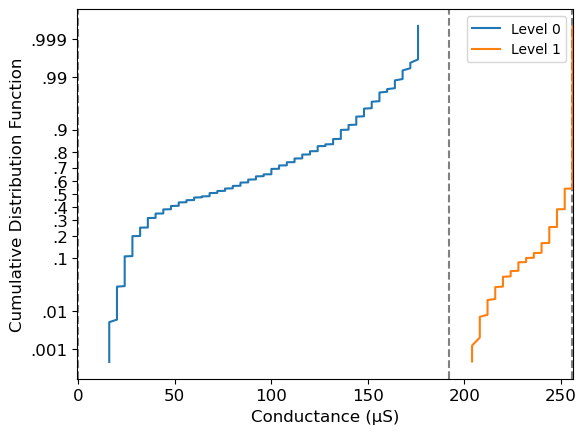

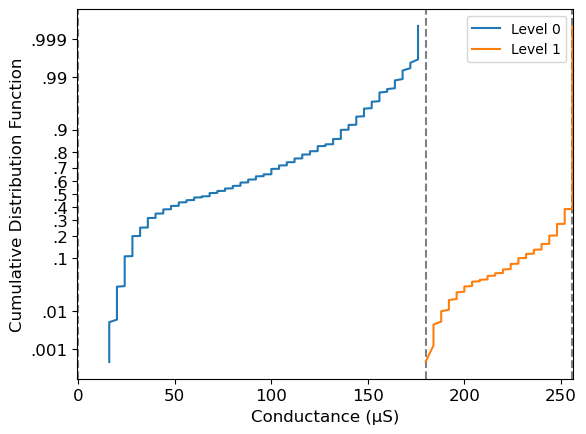

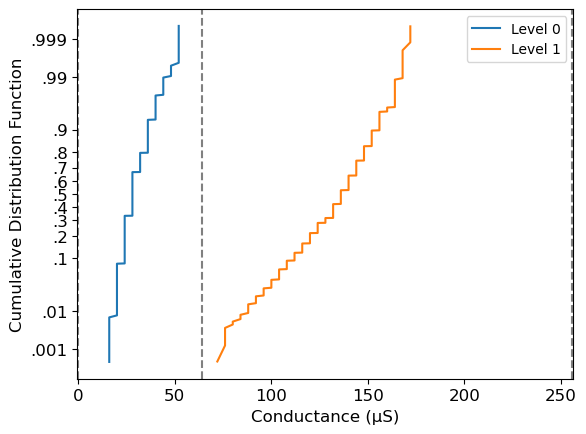

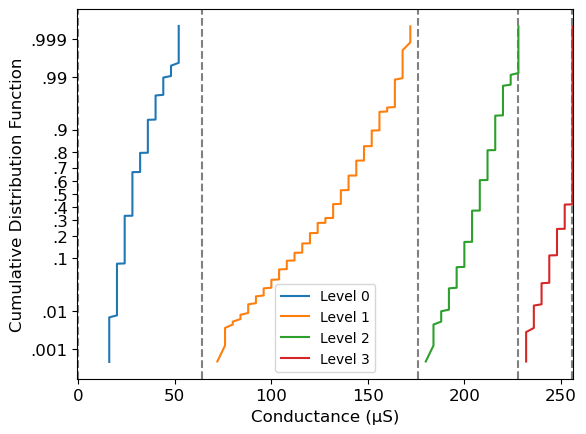

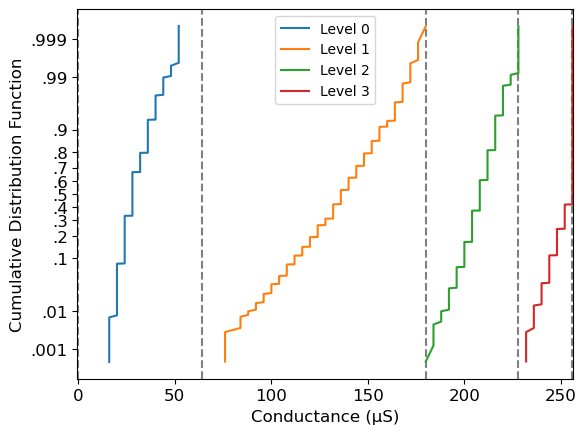

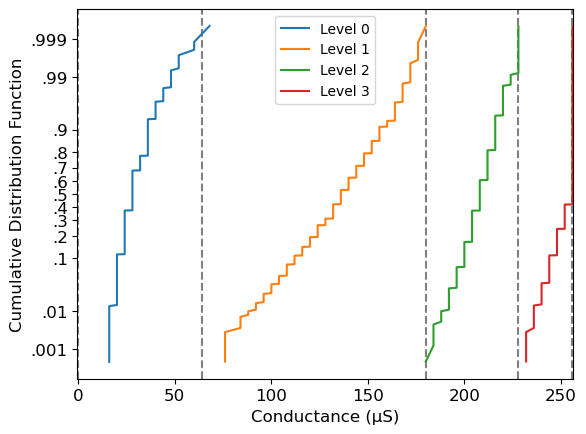

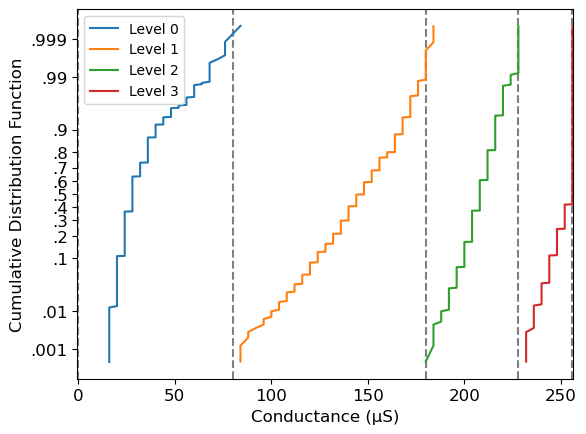

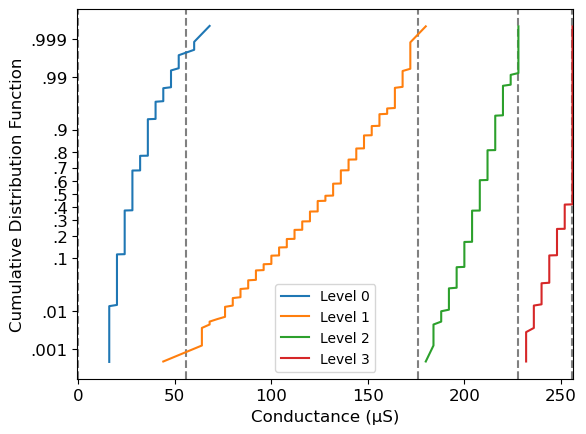

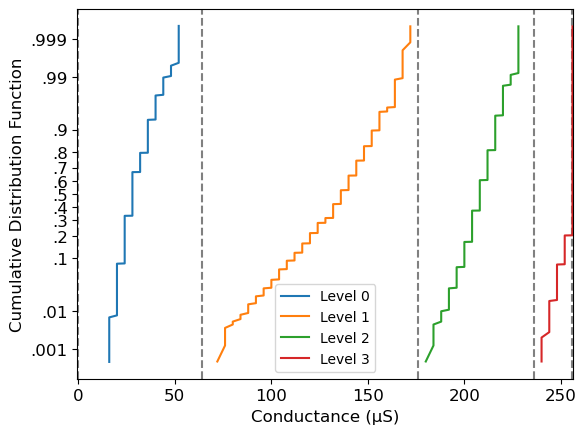

In [21]:
# Visualize allocations
for i, d in best.iterrows():
    plt.xlim(-0.5, 256.5)
    plt.gca().set_yscale("ppf")
    plt.xlabel("Conductance (µS)")
    plt.ylabel("Cumulative Distribution Function")
    for bound in d["read_bounds"]:
        plt.axvline(bound*4, color="gray", linestyle="--")
    for j, lvl in enumerate(d["allocation"]):
        # Get the relevant data
        lvldata = tdata[(tdata["timept"] == timept) & (tdata["lower"] == lvl[0]) & (tdata["upper"] == lvl[1])]

        # Plot distributions
        plt.plot(sorted(lvldata["lvl"].values * 4), np.linspace(0.5/len(lvldata["lvl"].values), 1-0.5/len(lvldata["lvl"].values), len(lvldata["lvl"].values)), label=f"Level {j}")
    plt.legend(fontsize=10)
    plt.show()

In [27]:
# Write out configs
import json
from copy import deepcopy
with open("../settings/config.json") as config_tmpl_file:
    config_tmpl = json.load(config_tmpl_file)

for i, d in best.iterrows():
    with open(f"../settings/opt/{d['bpc']}bpc_{'bwa' if not d['is_pba'] else 'pba'}_{i}.json", "w") as config_outfile:
        config = deepcopy(config_tmpl)
        config["num_levels"] = len(d["allocation"])
        config["level_settings"] = config["level_settings"][:config["num_levels"]]
        for lvl, ((lower_write, upper_write), read_bound) in enumerate(zip(d["allocation"], d["read_bounds"][1:])):
            if d["bpc"] == 1:
                config["level_settings"][lvl]["post_read_setup_cycles"] = 1
                config["level_settings"][lvl]["write_to_init_read_setup_cycles"] = 2
                config["level_settings"][lvl]["read_to_init_write_setup_cycles"] = 2
            config["level_settings"][lvl]["idle_to_init_read_setup_cycles"] = 63
            config["level_settings"][lvl]["adc_lower_write_ref_lvl"] = lower_write
            config["level_settings"][lvl]["adc_upper_write_ref_lvl"] = upper_write
            config["level_settings"][lvl]["adc_upper_read_ref_lvl"] = min(read_bound, 63)
        config["level_settings"][-1]["bl_dac_set_lvl_start"] = 16
        # config["level_settings"][0]["pw_rst_start_mantissa"] = 4
        # config["level_settings"][0]["pw_rst_step_mantissa"] = 4
        # config["level_settings"][0]["pw_rst_stop_mantissa"] = 8
        json.dump(config, config_outfile, indent=4)